<a href="https://colab.research.google.com/github/nazmus007/transformers_test/blob/main/distilbert_ptacek_run2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install -qq transformers

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 37.6 MB/s 
     |████████████████████████████████| 3.3 MB 45.2 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 636 kB 44.7 MB/s 


In [ ]:
print(transformers.__version__)

4.10.0


In [2]:
!pip install emoji

     |████████████████████████████████| 168 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=14a2ca1ae3b15e86d288e438b9aee987cc3aa17f7761d0c13d6770465d976c4a
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji


In [ ]:
torch.cuda.empty_cache()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu Sep 30 13:07:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import transformers

from transformers import DistilBertModel, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup, DistilBertForSequenceClassification

import torch
import re
import numpy as np
import pandas as pd

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

from textwrap import wrap

from torch import nn, optim

from torch.utils.data import Dataset, DataLoader

In [5]:

import torch.nn.functional as F

In [6]:
df = pd.read_csv("./drive/MyDrive/datasets/cleaned_ptacek_wtweets_wnotebook.csv")
df.head()

,Unnamed: 0,index,Tweet_id,Tweet,Label
0,0,0,411348816583856129,peyton obviously cannot finish games he just t...,1
1,1,1,408111537011036160,well i would love to be sleeping right now but...,1
2,2,2,403282506230665217,my biggest executive decision today choosing b...,1
3,3,3,409720467662983168,the first quality opponent they played in 2 y...,1
4,4,4,403005765608554496,but do not you dare call it hate crimes libe...,1


In [7]:
df= df.drop(['Unnamed: 0','index','Tweet_id'],axis=1)

In [8]:
!pip install demoji

     |████████████████████████████████| 42 kB 1.0 MB/s 


In [9]:
import demoji
def demoji_text(text):
  d= demoji.findall(text)
  return d

In [10]:
df['emoji_list'] = df['Tweet'].apply(demoji_text)

In [11]:
f= list(filter(None, df['emoji_list']))

In [12]:
print(f)

[{'😏': 'smirking face', '👌': 'OK hand'}, {'👍': 'thumbs up'}, {'😡': 'pouting face'}, {'🔫': 'water pistol', '😫': 'tired face', '😍': 'smiling face with heart-eyes', '🙈': 'see-no-evil monkey'}, {'😐': 'neutral face'}, {'😒': 'unamused face'}, {'👀': 'eyes', '😮': 'face with open mouth'}, {'🔫': 'water pistol', '😭': 'loudly crying face'}, {'👌': 'OK hand'}, {'😒': 'unamused face'}, {'😳': 'flushed face', '👌': 'OK hand'}, {'😣': 'persevering face'}, {'😒': 'unamused face'}, {'👌': 'OK hand'}, {'😒': 'unamused face'}, {'🙈': 'see-no-evil monkey'}, {'😒': 'unamused face'}, {'😊': 'smiling face with smiling eyes'}, {'👌': 'OK hand'}, {'😑': 'expressionless face'}, {'👍': 'thumbs up'}, {'🎉': 'party popper'}, {'😒': 'unamused face', '👏': 'clapping hands'}, {'😛': 'face with tongue'}, {'😒': 'unamused face'}, {'😻': 'smiling cat with heart-eyes'}, {'😑': 'expressionless face'}, {'😰': 'anxious face with sweat'}, {'😉': 'winking face'}, {'😳': 'flushed face'}, {'😭': 'loudly crying face'}, {'💁': 'person tipping hand'}, {'😡':

In [13]:
all_keys = set().union(*(d.keys() for d in f))

In [14]:
print(all_keys)

{'🙌', '🎌', '👣', '😐', '😦', '☝️', '🐒', '🌴', '😡', '📄', '🚙', '😺', '😴', '👼', '🔞', '👭', '⛅', '👬', '💳', '🇮🇹', '😧', '❄️', '😊', '🍹', '🎁', '💯', '🎂', '🍵', '▶', '👹', '😛', '👊', '😮', '🎋', '✈️', '😀', '🍉', '✴', '👀', '😩', '♥️', '🏥', '🍊', '✈', '📯', '🍭', '💸', '💌', '🌌', '🏂', '😖', '🍸', '🍝', '💘', '👏', '🐛', '🌸', '💄', '🍟', '😄', '💽', '🙆', '💨', '😈', '🐽', '🏄', '🎈', '📨', '🐭', '🌃', '🔯', '🐧', '🚔', '😝', '🎵', '🕥', '☕', '🆒', '🌽', '🌵', '👿', '🐾', '💎', '🎨', '🍧', '💪', '🚗', '🔫', '😲', '🎹', '🐸', '☹', '😁', '👜', '🚬', '🌱', '😔', '👳', '❤', '☀️', '🌁', '😃', '🐉', '😬', '💃', '😚', '👱', '😵', '▪', '🍖', '👩', '🐴', '🆘', '🐼', '❗', '™', '🎻', '♦', '🍦', '🍷', '🚀', '◾', '☠', '🙅', '🌍', '🙊', '😌', '🎺', '✋', '🍏', '😥', '🎊', '🐤', '🇩🇪', '👔', '💟', '🍨', '😋', '💍', '📺', '😓', '👾', '🙀', '💤', '🌠', '😷', '🔥', '✊', '⚡', '❄', '😞', '💢', '🌊', '🎿', '❌', '❤️', '🍆', '®', '👠', '🎾', '😏', '👰', '🎎', '🕐', '🇺🇸', '🎉', '🚨', '💞', '🐶', '😎', '💏', '🌀', '😰', '🚼', '💁', '🍳', '👎', '🍈', '👻', '⏰', '🏊', '💣', '📓', '😻', '🙏', '🍰', '👸', '☁️', '😫', '🌎', '🍺', '😜', '💔', '⚽', '💖', '👋', '🎄', '🍁',

In [15]:
import emoji
def extract_emojis(s):
    return ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in s)

In [16]:
df['Tweet'] = df['Tweet'].apply(extract_emojis)

In [17]:
df.columns = df.columns.str.lstrip()

In [18]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


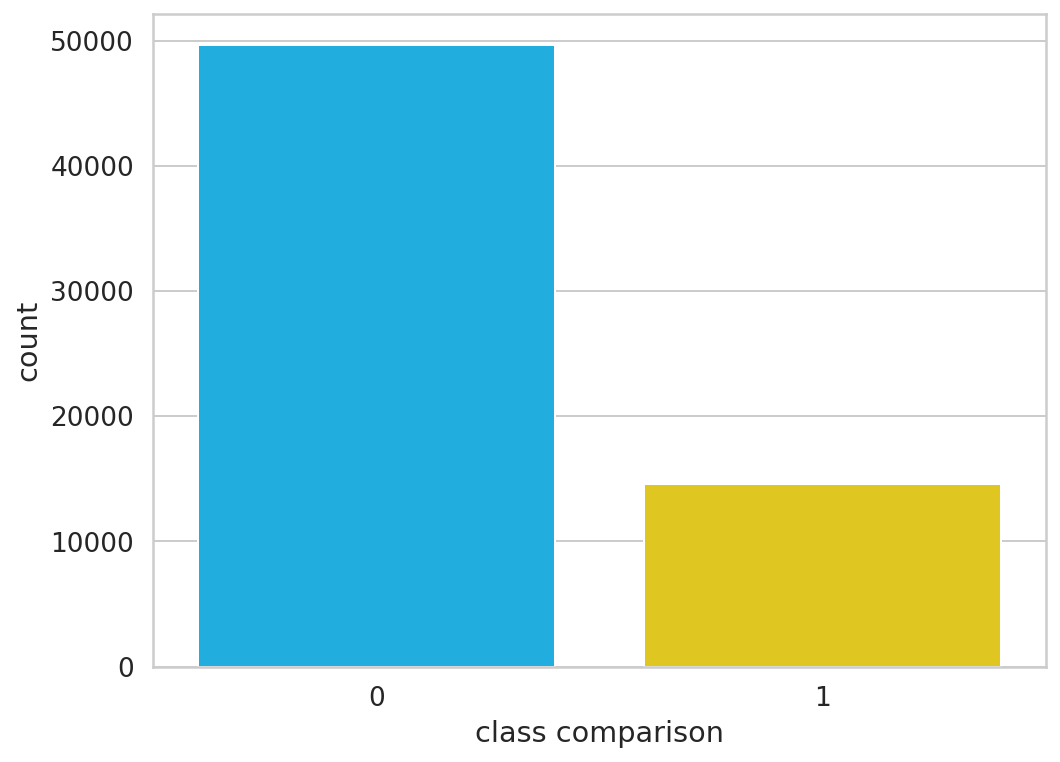

In [19]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.Label)
plt.xlabel('class comparison');

In [ ]:
emoji_1 = re.compile('[\\u203C-\\u3299\\U0001F000-\\U0001F644]')

In [ ]:
emoji_list= list(filter(emoji_1.match, df['Tweet text']))

In [ ]:
emoji_list_2= list(filter(emoji_1.match,df['Emoji list']))

TypeError: ignored

In [ ]:
print(emoji_list)

['👊 fistbump positive focus starve distractions werk motivation createpath uplift success ', '😒 half of the testing group was very helpful today ', '🙀😱🙀😱🙀😱 popcorn 😂🎅😂🎅😂🔫🔫 bringing this at movie tuesday night  ', '🇫🇴🇱🇱🇴🇼 thistsu website now worth 15 millionyou get paid for posting ', '😂😂 i will let you and bb know how i get on xx', '🎉it is monday 🎉 ']


In [ ]:
emo_found= ' '.join(emoji for emoji in emoji_list)

In [ ]:
from emoji import UNICODE_EMOJI

def get_emoji_set(text):
    return {letter for letter in text if letter in UNICODE_EMOJI['en'] }

In [ ]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')


In [ ]:
print(c)

{'🔫', '😱', '🎅', '😂', '👊', '🎉', '😒', '🙀'}


In [ ]:
df.head()

,Tweet,Label
0,peyton obviously cannot finish games he just t...,1
1,well i would love to be sleeping right now but...,1
2,my biggest executive decision today choosing b...,1
3,the first quality opponent they played in 2 y...,1
4,but do not you dare call it hate crimes libe...,1


In [ ]:
df['Label'] = df['Label'].map({1: 'sarcasm', 0: 'Non-sarcasm'})


In [ ]:
df.head()

,Label,Tweet
517,0,#Heisenberg Uncertainty Principle: Whatever yo...
800,0,Don't forget the true meaning of Christmas:per...
381,0,Happy new year to meeeee... http://t.co/ZLtXiV...
2092,1,@SerJeyms: This year's class picture is so awe...
2436,1,@TheLouieMiguel what a way to start the new year


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


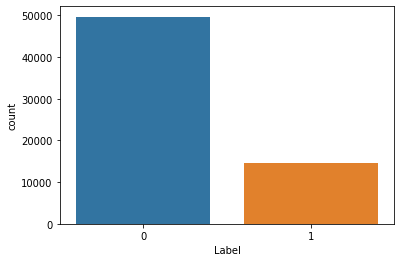

In [ ]:
sns.countplot(df.Label)
plt.xlabel('Label');


In [ ]:
!pip install sentencepiece

In [20]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'

In [21]:
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer.add_tokens(['🙌', '🎌', '👣', '😐', '😦', '☝️', '🐒', '🌴', '😡', '📄', '🚙', '😺', '😴', '👼', '🔞', '👭', '⛅', '👬', '💳', '🇮🇹', '😧', '❄️', '😊', '🍹', '🎁', '💯', '🎂', '🍵', '▶', '👹', '😛', '👊', '😮', '🎋', '✈️', '😀', '🍉', '✴', '👀', '😩', '♥️', '🏥', '🍊', '✈', '📯', '🍭', '💸', '💌', '🌌', '🏂', '😖', '🍸', '🍝', '💘', '👏', '🐛', '🌸', '💄', '🍟', '😄', '💽', '🙆', '💨', '😈', '🐽', '🏄', '🎈', '📨', '🐭', '🌃', '🔯', '🐧', '🚔', '😝', '🎵', '🕥', '☕', '🆒', '🌽', '🌵', '👿', '🐾', '💎', '🎨', '🍧', '💪', '🚗', '🔫', '😲', '🎹', '🐸', '☹', '😁', '👜', '🚬', '🌱', '😔', '👳', '❤', '☀️', '🌁', '😃', '🐉', '😬', '💃', '😚', '👱', '😵', '▪', '🍖', '👩', '🐴', '🆘', '🐼', '❗', '™', '🎻', '♦', '🍦', '🍷', '🚀', '◾', '☠', '🙅', '🌍', '🙊', '😌', '🎺', '✋', '🍏', '😥', '🎊', '🐤', '🇩🇪', '👔', '💟', '🍨', '😋', '💍', '📺', '😓', '👾', '🙀', '💤', '🌠', '😷', '🔥', '✊', '⚡', '❄', '😞', '💢', '🌊', '🎿', '❌', '❤️', '🍆', '®', '👠', '🎾', '😏', '👰', '🎎', '🕐', '🇺🇸', '🎉', '🚨', '💞', '🐶', '😎', '💏', '🌀', '😰', '🚼', '💁', '🍳', '👎', '🍈', '👻', '⏰', '🏊', '💣', '📓', '😻', '🙏', '🍰', '👸', '☁️', '😫', '🌎', '🍺', '😜', '💔', '⚽', '💖', '👋', '🎄', '🍁', '😭', '😨', '☁', '🌏', '◽', '🔪', '☔', '💛', '🌞', '💗', '👫', '☀', '💩', '🍗', '🍀', '😱', '🚶', '🎷', '🏈', '✖️', '💜', '👂', '💵', '🚺', '🌲', '🌻', '🔄', '🇬🇧', '😯', '👆', '🎮', '🇫🇷', '🕑', '🐣', '🍬', '🍔', '☺️', '😆', '🌙', '😘', '🍲', '💅', '💐', '🎼', '💂', '🙈', '🚓', '⬅️', '🐠', '➡️', '🍫', '🍠', '😗', '💧', '📀', '🍓', '💚', '⭐', '🔆', '🎥', '👑', '👙', '🎭', '😹', '🚫', '🙍', '🍋', '©', '✌️', '🚢', '🐟', '🏡', '👄', '👯', '📑', '😒', '⛄', '😑', '🐥', '💻', '🎤', '👐', '👈', '😢', '🍕', '😟', '📱', '🏃', '🌚', '💊', '🐬', '😍', '🍪', '👅', '😿', '🚴', '🎅', '💋', '💰', '☃', '☮', '😅', '😉', '💝', '📚', '💉', '✨', '✌', '😽', '🎶', '😙', '😳', '♥', '🌂', '☂', '🐇', '👌', '💦', '👪', '〰', '🙋', '✖', '🍻', '🎆', '☺', '🌆', '⁉️', '🔮', '🐰', '🍩', '😣', '😇', '😤', '✔️', '✏', '🍛', '🐳', '🏰', '💆', '♏', '😶', '🐷', '💥', '📣', '🎓', '😠', '🍃', '👍', '💀', '😂', '👃', '😪', '💼', '📖', '🌅', '🍍', '🎀', '🙉', '💙', '🎧', '🍤', '🎸', '👉', '🍅', '🌾', '💕', '⛪', '😕', '🔅', '👶'])


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

362

In [22]:
sample_txt = 'the roads look really bad to me 😏 i think we need another day without school 👌'

In [23]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: the roads look really bad to me 😏 i think we need another day without school 👌
   Tokens: ['the', 'roads', 'look', 'really', 'bad', 'to', 'me', '😏', 'i', 'think', 'we', 'need', 'another', 'day', 'without', 'school', '👌']
Token IDs: [1996, 4925, 2298, 2428, 2919, 2000, 2033, 30678, 1045, 2228, 2057, 2342, 2178, 2154, 2302, 2082, 30830]


In [24]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [25]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  1996,  4925,  2298,  2428,  2919,  2000,  2033, 30678,  1045,
         2228,  2057,  2342,  2178,  2154,  2302,  2082, 30830,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [26]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [27]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'the',
 'roads',
 'look',
 'really',
 'bad',
 'to',
 'me',
 '😏',
 'i',
 'think',
 'we',
 'need',
 'another',
 'day',
 'without',
 'school',
 '👌',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [28]:
token_lens = []

for txt in df.Tweet:
  tokens = tokenizer.encode(txt, max_length=256)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


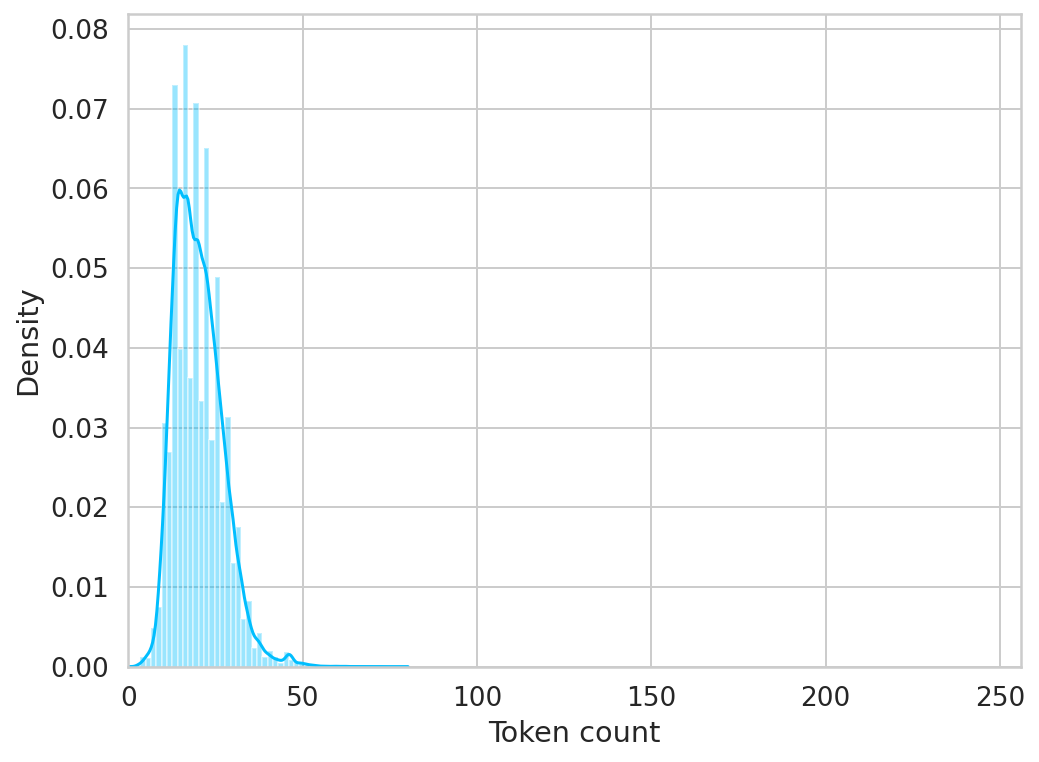

In [29]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [30]:
MAX_LEN = 128

In [31]:
class SarcasmDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [32]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=RANDOM_SEED)

In [33]:
df_train.shape, df_val.shape, df_test.shape

((51387, 3), (8992, 3), (3855, 3))

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SarcasmDataset(
    tweets=df.Tweet.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [35]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [36]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [37]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [38]:
bert_model_1 = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,output_hidden_states=True)
bert_model_1.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(30884, 768)

In [39]:
last_hidden_state, pooled_output = bert_model_1(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict = False
)

In [40]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [41]:
bert_model_1.config.hidden_size

768

In [42]:
pooled_output.shape

AttributeError: ignored

In [43]:
class SarcasmClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SarcasmClassifier, self).__init__()
    self.l1 = bert_model_1
    self.pre_classifier = torch.nn.Linear(768, 768)
    self.dropout = torch.nn.Dropout(0.3)
    self.classifier = torch.nn.Linear(768, 2)
  def forward(self, input_ids, attention_mask):
    output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
    hidden_state = output_1[0]
    pooler = hidden_state[:, 0]
    pooler = self.pre_classifier(pooler)
    pooler = torch.nn.ReLU()(pooler)
    pooler = self.dropout(pooler)
    output = self.classifier(pooler)
    return output
    

In [44]:
class_names=['1', '0']

In [45]:
len(class_names)

2

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

In [46]:
model = SarcasmClassifier(len(class_names))
model = model.to(device)

In [47]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [48]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5264, 0.4736],
        [0.4937, 0.5063],
        [0.5155, 0.4845],
        [0.4883, 0.5117],
        [0.5248, 0.4752],
        [0.4663, 0.5337],
        [0.4791, 0.5209],
        [0.4904, 0.5096],
        [0.4854, 0.5146],
        [0.5133, 0.4867],
        [0.5054, 0.4946],
        [0.4834, 0.5166],
        [0.4707, 0.5293],
        [0.4704, 0.5296],
        [0.5121, 0.4879],
        [0.5212, 0.4788],
        [0.5159, 0.4841],
        [0.4932, 0.5068],
        [0.4917, 0.5083],
        [0.4874, 0.5126],
        [0.5074, 0.4926],
        [0.5375, 0.4625],
        [0.5254, 0.4746],
        [0.4756, 0.5244],
        [0.4673, 0.5327],
        [0.4745, 0.5255],
        [0.5078, 0.4922],
        [0.4783, 0.5217],
        [0.5030, 0.4970],
        [0.5510, 0.4490],
        [0.4768, 0.5232],
        [0.4977, 0.5023]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [49]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [50]:
EPOCHS = 5

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps= 1e-8)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [51]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [53]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'distilbert_ptacek_wemoji_run2.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.313469617060417 accuracy 0.8589721135695798


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.2612289898760378 accuracy 0.8881227758007118

Epoch 2/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.20066896250650082 accuracy 0.9183061863895537


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.2879213550959936 accuracy 0.8889012455516013

Epoch 3/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.1272084059113704 accuracy 0.9532761204195613


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4036623741370821 accuracy 0.8893460854092526

Epoch 4/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.08115173543994472 accuracy 0.9737093039095491


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5025504049990042 accuracy 0.8899021352313167

Epoch 5/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.05610197224259344 accuracy 0.9831864090139529


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.545857952013645 accuracy 0.890903024911032

CPU times: user 28min 16s, sys: 12.4 s, total: 28min 28s
Wall time: 28min 25s


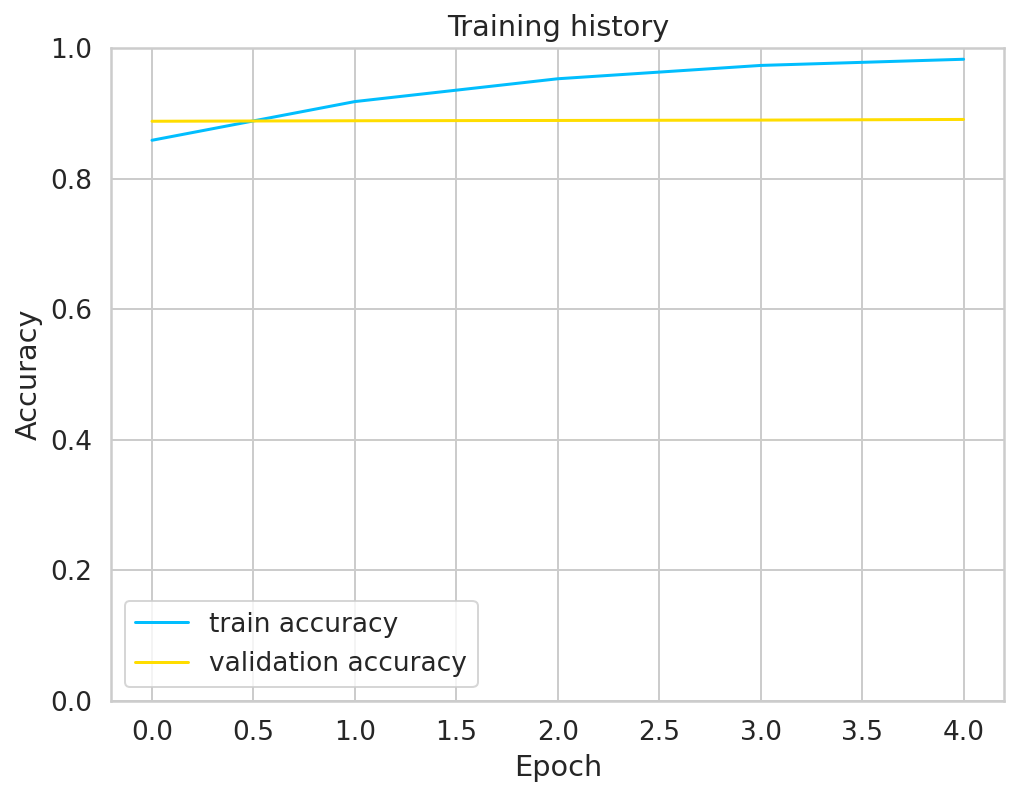

In [54]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

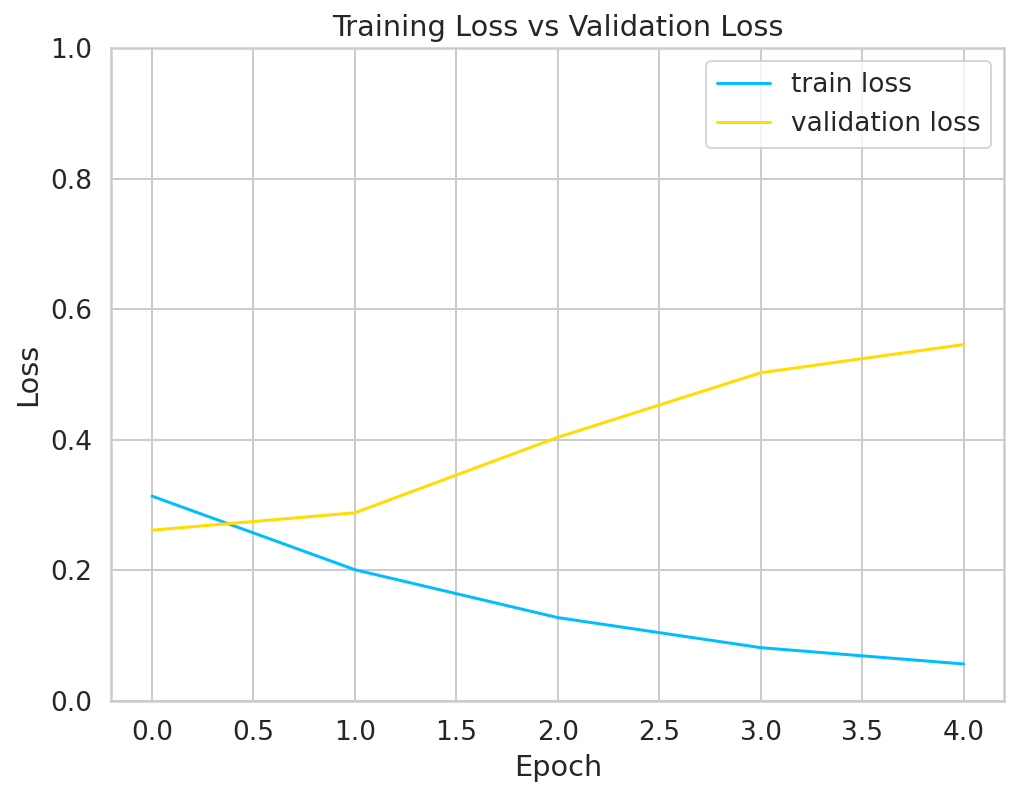

In [55]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [56]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

In [57]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [58]:
print(classification_report(y_test, y_pred,labels=[1,0]))

              precision    recall  f1-score   support

           1       0.78      0.72      0.75       866
           0       0.92      0.94      0.93      2989

    accuracy                           0.89      3855
   macro avg       0.85      0.83      0.84      3855
weighted avg       0.89      0.89      0.89      3855



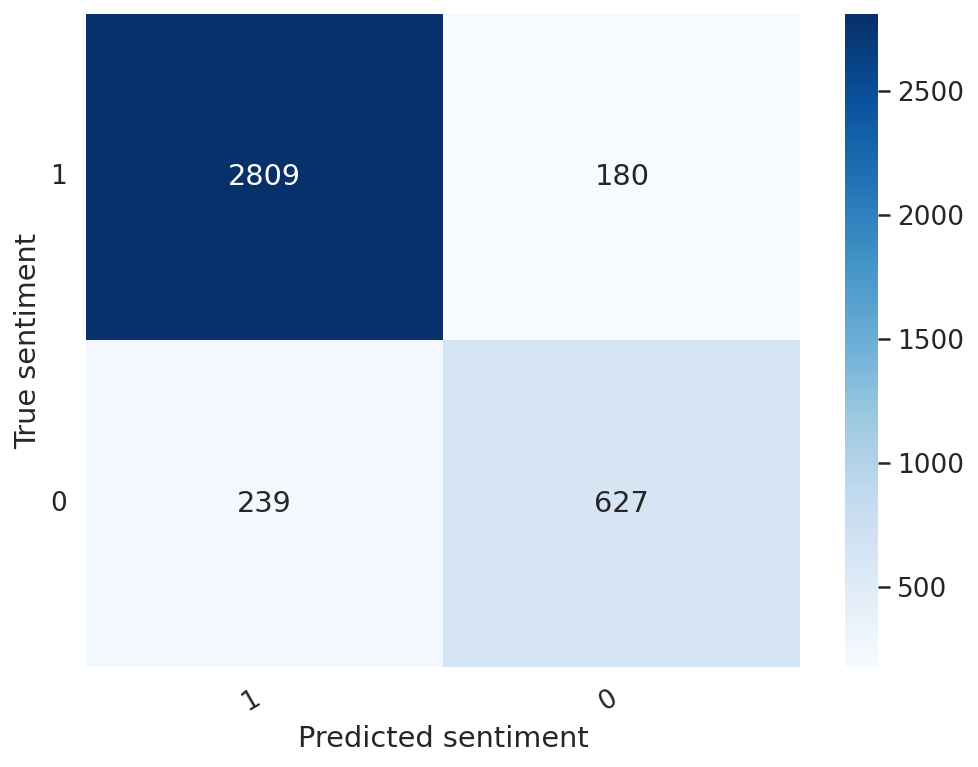

In [59]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [60]:
idx = 2

tweet_text = y_tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [61]:
print("\n".join(wrap(tweet_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

i am sorry but whoever took this timeout is high on turkey and rum
pitvsbal

True sentiment: 1


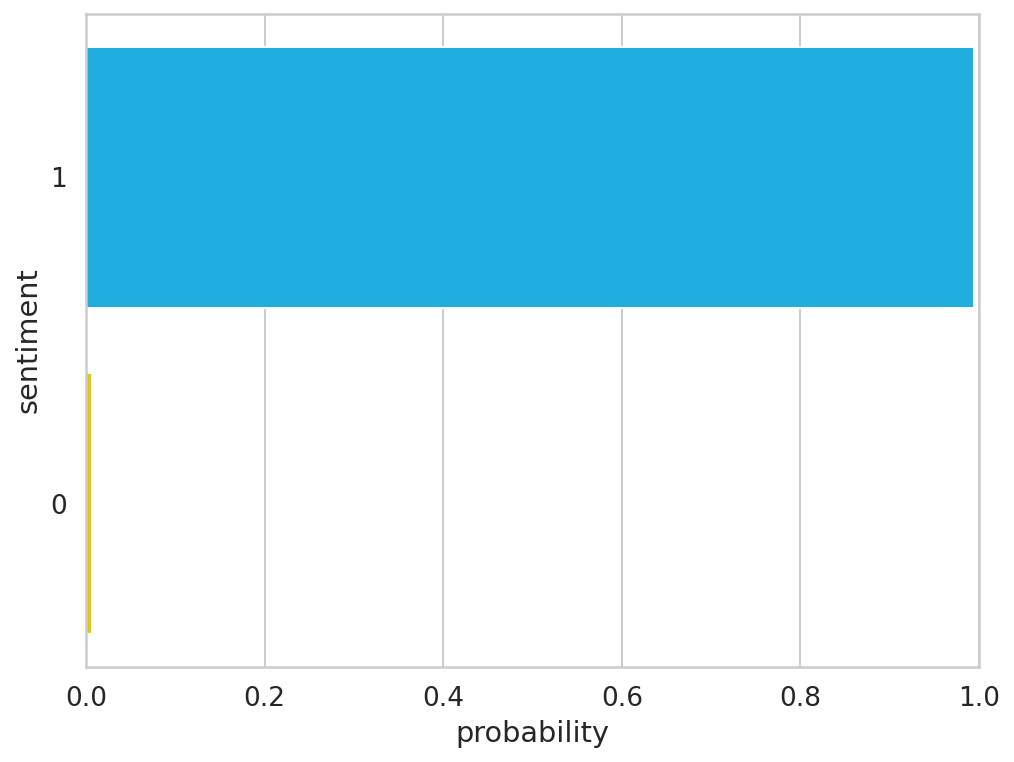

In [62]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [63]:
review_text = "Oh thank GOD our entire office email system is down... the day of a big event. Santa you know JUST what to get me for xmas"

In [64]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [65]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Tweet text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Tweet text: Oh thank GOD our entire office email system is down... the day of a big event. Santa you know JUST what to get me for xmas
Sentiment  : 0
